In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# manual pip install
from kmodes.kprototypes import KPrototypes
from scipy import stats
from sklearn.feature_selection import chi2, f_classif
from scipy.stats import chi2_contingency,f_oneway

# manual pip install
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import confusion_matrix, accuracy_score, classification_report




# Read Data 

In [2]:
bankChurners_Raw = pd.read_csv('BankChurners_raw.csv')
bankChurners_Raw = bankChurners_Raw[['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
                                    'Education_Level','Marital_Status','Income_Category','Card_Category',
                                     'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
                                     'Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal', 'Avg_Open_To_Buy',
                                     'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct','Total_Ct_Chng_Q4_Q1',
                                     'Avg_Utilization_Ratio']]
bankChurners_Raw.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


# DATA CHECK

In [3]:
# Null Value Check 
bankChurners_Raw.isnull().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [4]:
# Duplicate Value Check 
bankChurners_Raw=bankChurners_Raw.drop_duplicates()
bankChurners_Raw.shape

(10127, 21)

# Summary Statistics

In [5]:
bankChurners_Raw.describe(include= 'object').transpose().reset_index()


,index,count,unique,top,freq
0,Attrition_Flag,10127,2,Existing Customer,8500
1,Gender,10127,2,F,5358
2,Education_Level,10127,7,Graduate,3128
3,Marital_Status,10127,4,Married,4687
4,Income_Category,10127,6,Less than $40K,3561
5,Card_Category,10127,4,Blue,9436


In [6]:
bankChurners_Raw[['Customer_Age','Dependent_count','Months_on_book','Total_Relationship_Count',
                'Months_Inactive_12_mon','Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
                'Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Trans_Ct',
                'Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']].describe().transpose().reset_index()

,index,count,mean,std,min,25%,50%,75%,max
0,Customer_Age,10127.0,46.325960,8.016814,26.0,41.000,46.000,52.000,73.000
1,Dependent_count,10127.0,2.346203,1.298908,0.0,1.000,2.000,3.000,5.000
2,Months_on_book,10127.0,35.928409,7.986416,13.0,31.000,36.000,40.000,56.000
3,Total_Relationship_Count,10127.0,3.812580,1.554408,1.0,3.000,4.000,5.000,6.000
4,Months_Inactive_12_mon,10127.0,2.341167,1.010622,0.0,2.000,2.000,3.000,6.000
5,Contacts_Count_12_mon,10127.0,2.455317,1.106225,0.0,2.000,2.000,3.000,6.000
6,Credit_Limit,10127.0,8631.953698,9088.776650,1438.3,2555.000,4549.000,11067.500,34516.000
7,Total_Revolving_Bal,10127.0,1162.814061,814.987335,0.0,359.000,1276.000,1784.000,2517.000
8,Avg_Open_To_Buy,10127.0,7469.139637,9090.685324,3.0,1324.500,3474.000,9859.000,34516.000
9,Total_Amt_Chng_Q4_Q1,10127.0,0.759941,0.219207,0.0,0.631,0.736,0.859,3.397


# Clean Data

Clean Nominal Data

In [7]:


# replace unknown values to mode 
bankChurners_Raw['Education_Level'] = bankChurners_Raw['Education_Level'].replace("Unknown","Graduate")
bankChurners_Raw['Marital_Status'] = bankChurners_Raw['Marital_Status'].replace("Unknown","Married")
bankChurners_Raw['Income_Category'] = bankChurners_Raw['Income_Category'].replace("Unknown","Less than $40K")



Clean Integer Data 

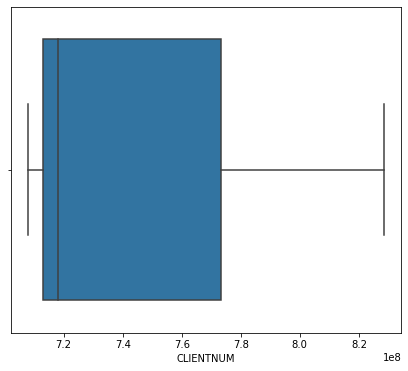

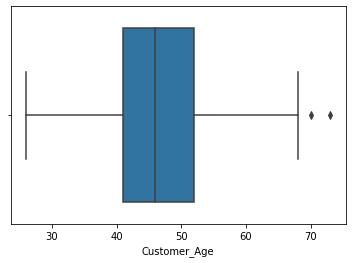

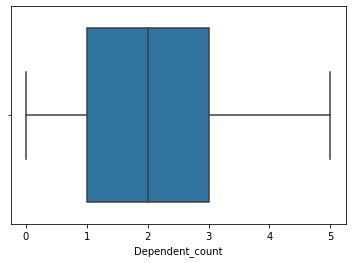

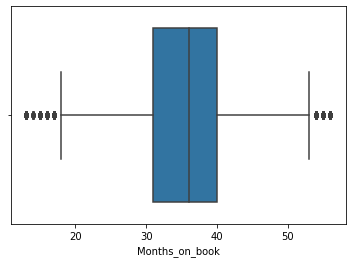

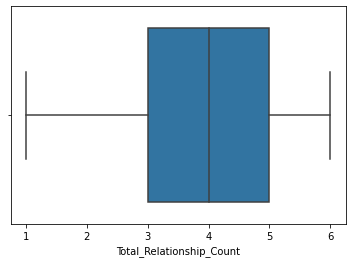

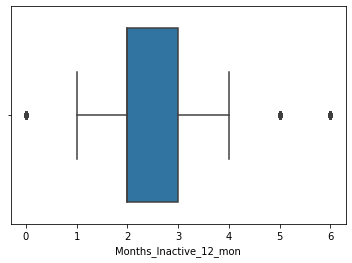

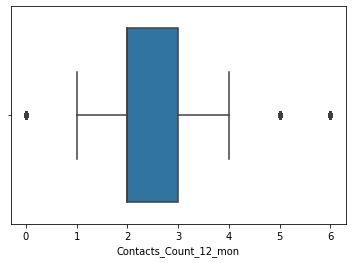

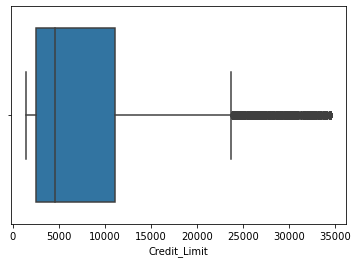

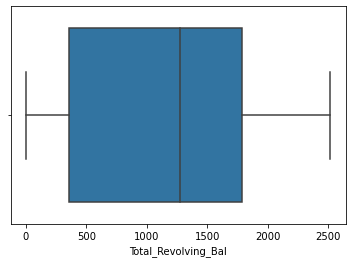

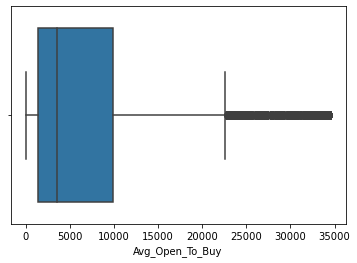

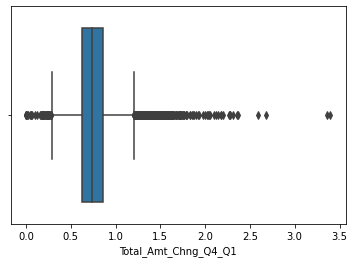

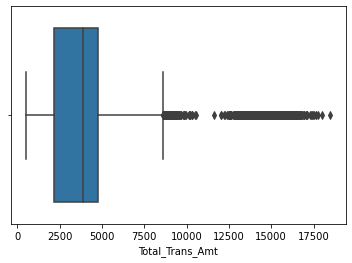

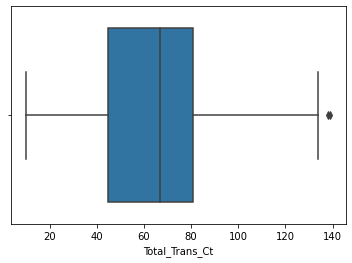

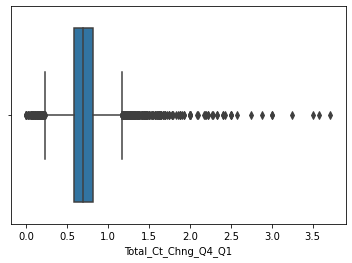

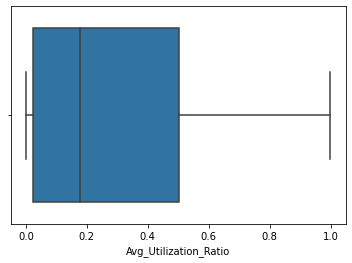

In [8]:
plt.figure(figsize=[7,6])
num_cols = bankChurners_Raw.select_dtypes(['int64','float64']).columns
for i in range(len(num_cols)):
    sns.boxplot(bankChurners_Raw[num_cols[i]])
    plt.show()

In [9]:
def treat_outlier(x):
    q5 = np.percentile(x,5)
    q25= np.percentile(x,25)
    q75= np.percentile(x,75)
    up_trend=np.percentile(x,95)
    IQR = q75-q25
    LTV = q25-(1.5*IQR)
    UTV = q75+(1.5*IQR)
    
    return x.apply(lambda y: up_trend if y> UTV else y).apply(lambda y: q5 if y < LTV else y)

outlier_list = ['Customer_Age','Months_on_book','Months_Inactive_12_mon','Contacts_Count_12_mon',
                'Total_Trans_Ct']

for i in bankChurners_Raw[outlier_list]:
    bankChurners_Raw[i]=treat_outlier(bankChurners_Raw[i])

# Code Categorical Variables to Numbers

In [10]:
# Encode Attrition_Flag
bankChurners_Raw['Attrition_Flag'] = bankChurners_Raw['Attrition_Flag'].replace({'Existing Customer' : 0, 'Attrited Customer' : 1})

bankChurners_Raw.head()


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,0,45.0,M,3,High School,Married,$60K - $80K,Blue,39.0,...,1.0,3.0,12691.0,777,11914.0,1.335,1144,42.0,1.625,0.061
1,818770008,0,49.0,F,5,Graduate,Single,Less than $40K,Blue,44.0,...,1.0,2.0,8256.0,864,7392.0,1.541,1291,33.0,3.714,0.105
2,713982108,0,51.0,M,3,Graduate,Married,$80K - $120K,Blue,36.0,...,1.0,1.0,3418.0,0,3418.0,2.594,1887,20.0,2.333,0.000
3,769911858,0,40.0,F,4,High School,Married,Less than $40K,Blue,34.0,...,4.0,1.0,3313.0,2517,796.0,1.405,1171,20.0,2.333,0.760
4,709106358,0,40.0,M,3,Uneducated,Married,$60K - $80K,Blue,21.0,...,1.0,1.0,4716.0,0,4716.0,2.175,816,28.0,2.500,0.000


# Feature Selection

In [11]:
categorical_var = ['Attrition_Flag','Gender','Education_Level','Marital_Status','Income_Category','Card_Category']
numerical_var = ['Customer_Age','Dependent_count','Months_on_book','Total_Relationship_Count',
                 'Months_Inactive_12_mon','Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal',
                 'Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1',
                 'Avg_Utilization_Ratio']




Hypothesis Testing for Categorical Variables

In [12]:
chi2_check = []
p_values = []
for feature in categorical_var[1:]:   
    if chi2_contingency(pd.crosstab(bankChurners_Raw['Attrition_Flag'],bankChurners_Raw[feature]))[1] <= 0.05:
        chi2_check.append('Reject Null Hypothesis')
        p_values.append(chi2_contingency(pd.crosstab(bankChurners_Raw['Attrition_Flag'],bankChurners_Raw[feature]))[1])
    else:
        chi2_check.append('Accept Null Hypothesis')
        p_values.append(chi2_contingency(pd.crosstab(bankChurners_Raw['Attrition_Flag'],bankChurners_Raw[feature]))[1])

data = pd.DataFrame(data=[categorical_var[1:],chi2_check,p_values]).T
data.columns = ['Column','Hypothesis', 'P-value']

marital = []
chi2_check2 = []
p_values2 = []


print(data)

            Column              Hypothesis      P-value
0           Gender  Reject Null Hypothesis  0.000196358
1  Education_Level  Reject Null Hypothesis    0.0464464
2   Marital_Status  Accept Null Hypothesis     0.138615
3  Income_Category  Reject Null Hypothesis    0.0125838
4    Card_Category  Accept Null Hypothesis     0.525238


Hypothesis testing for Numerical Variables

In [13]:
f_values = []
p_values = []
hypothesis = []

for feature in numerical_var:
    if(f_classif(bankChurners_Raw[[feature]],bankChurners_Raw[['Attrition_Flag']])[1] <= 0.05):
        hypothesis.append("Reject Null Hypothesis")
        f_values.append(f_classif(bankChurners_Raw[[feature]],bankChurners_Raw[['Attrition_Flag']])[0][0])
        p_values.append(f_classif(bankChurners_Raw[[feature]],bankChurners_Raw[['Attrition_Flag']])[1][0])
    else:
        hypothesis.append("Accept Null Hypothesis")
        f_values.append(f_classif(bankChurners_Raw[[feature]],bankChurners_Raw[['Attrition_Flag']])[0][0])
        p_values.append(f_classif(bankChurners_Raw[[feature]],bankChurners_Raw[['Attrition_Flag']])[1][0])

numerical_relationship = pd.DataFrame(data=[numerical_var,f_values,p_values,hypothesis]).T
numerical_relationship.columns = ['Column','F-Values','p-values','Hypothesis']
print(numerical_relationship)

                      Column    F-Values      p-values              Hypothesis
0               Customer_Age     3.40665     0.0649632  Accept Null Hypothesis
1            Dependent_count     3.65283     0.0560024  Accept Null Hypothesis
2             Months_on_book     1.90607       0.16743  Accept Null Hypothesis
3   Total_Relationship_Count     233.073   4.82928e-52  Reject Null Hypothesis
4     Months_Inactive_12_mon     318.186   4.22873e-70  Reject Null Hypothesis
5      Contacts_Count_12_mon     352.463   2.51347e-77  Reject Null Hypothesis
6               Credit_Limit     5.77373     0.0162854  Reject Null Hypothesis
7        Total_Revolving_Bal     752.702  6.63015e-160  Reject Null Hypothesis
8            Avg_Open_To_Buy  0.00082285      0.977116  Accept Null Hypothesis
9       Total_Amt_Chng_Q4_Q1     176.962   4.83664e-40  Reject Null Hypothesis
10           Total_Trans_Amt     296.228   1.85744e-65  Reject Null Hypothesis
11            Total_Trans_Ct     1621.44            

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Correlation Map

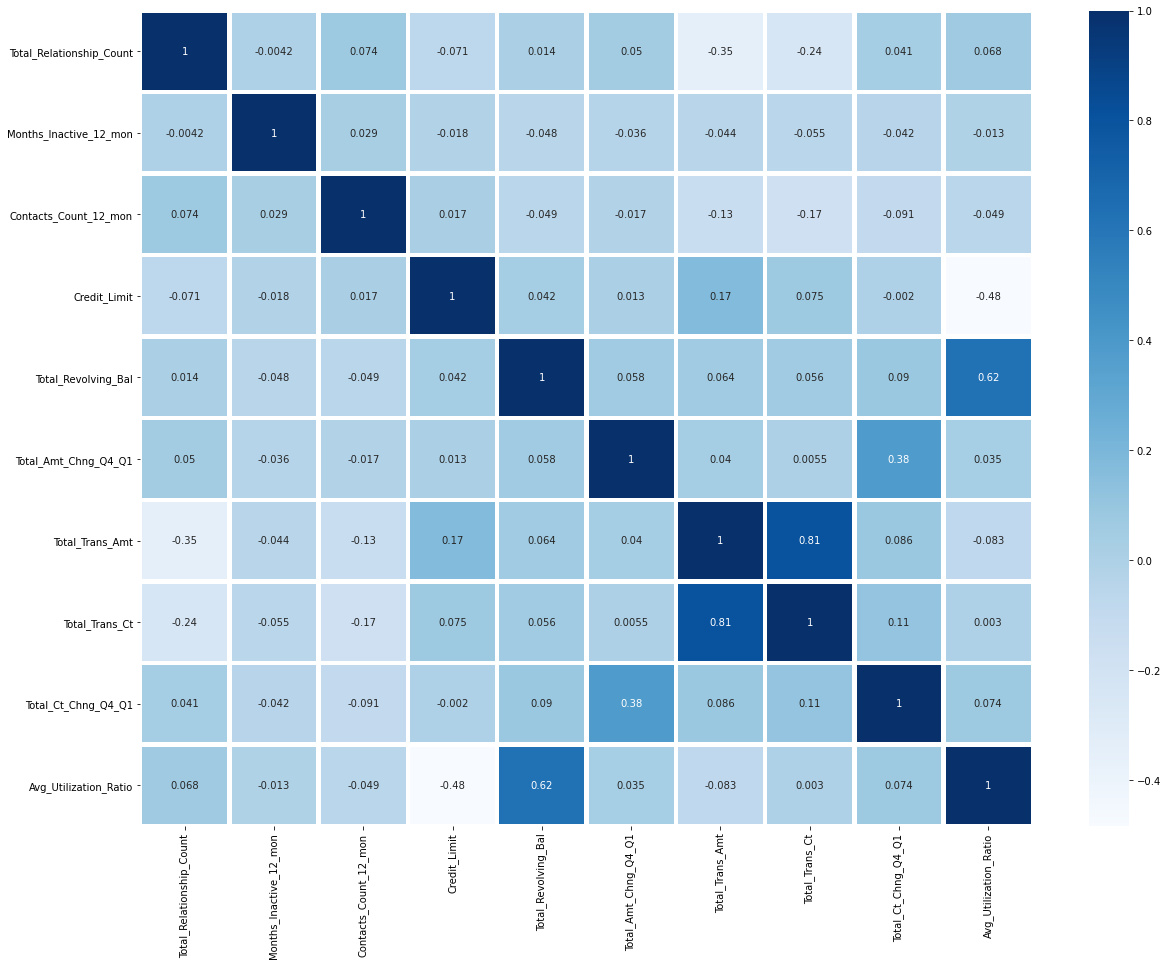

In [14]:
bankChurners_corr = bankChurners_Raw[['Total_Relationship_Count','Months_Inactive_12_mon',
                                      'Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal',
                                      'Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Trans_Ct',
                                      'Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']]


corrmat = bankChurners_corr.corr()
top_corr_features = corrmat.index

plt.figure(figsize=(20,15))

#plot heat map
g=sns.heatmap(bankChurners_corr[top_corr_features].corr(),annot=True,cmap="Blues",linewidths=3.5,
    linecolor='white')

bankChurners_transformed =bankChurners_Raw[['Attrition_Flag','Gender','Education_Level', 'Income_Category',
                                      'Total_Relationship_Count','Months_Inactive_12_mon',
                                      'Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal',
                                      'Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Trans_Ct',
                                      'Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']].copy()




# Scaling

In [15]:
# Scaling numeric variables 
transformed_numeric = ['Total_Relationship_Count','Months_Inactive_12_mon',
                       'Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal',
                       'Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Trans_Ct',
                       'Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']

for col in bankChurners_transformed[transformed_numeric]:
    bankChurners_transformed[col] = MinMaxScaler().fit_transform(bankChurners_transformed[[col]])
    
bankChurners_transformed

,Attrition_Flag,Gender,Education_Level,Income_Category,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,M,High School,$60K - $80K,0.8,0.000000,0.666667,0.340190,0.308701,0.392994,0.035273,0.258065,0.437534,0.061061
1,0,F,Graduate,Less than $40K,1.0,0.000000,0.333333,0.206112,0.343266,0.453636,0.043452,0.185484,1.000000,0.105105
2,0,M,Graduate,$80K - $120K,0.6,0.000000,0.000000,0.059850,0.000000,0.763615,0.076611,0.080645,0.628164,0.000000
3,0,F,High School,Less than $40K,0.4,1.000000,0.000000,0.056676,1.000000,0.413600,0.036775,0.080645,0.628164,0.760761
4,0,M,Uneducated,$60K - $80K,0.8,0.000000,0.000000,0.099091,0.000000,0.640271,0.017025,0.145161,0.673129,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0,M,Graduate,$40K - $60K,0.4,0.333333,0.666667,0.077536,0.735399,0.206947,0.832647,0.862903,0.230749,0.462462
10123,1,M,Graduate,$40K - $60K,0.6,0.333333,0.666667,0.085819,0.868494,0.236679,0.459219,0.475806,0.183899,0.511512
10124,1,F,High School,Less than $40K,0.8,0.666667,1.000000,0.120042,0.000000,0.241095,0.544175,0.403226,0.220248,0.000000
10125,1,M,Graduate,$40K - $60K,0.6,0.666667,0.666667,0.116172,0.000000,0.157492,0.438689,0.419355,0.194400,0.000000


# Dummy variables, training and SMOTE

In [16]:

bankChurners_model = bankChurners_transformed.copy()



# Split target & features
unclustered_x = bankChurners_model.drop('Attrition_Flag', axis=1)
unclustered_y = bankChurners_model['Attrition_Flag']


# Get dummy variables
unclustered_x = pd.get_dummies(unclustered_x)

# Training
x_train, x_test, y_train, y_test = train_test_split(unclustered_x , unclustered_y, test_size = 0.2)

print(f'''Shape of X before SMOTE:\n {y_train.value_counts()}''')

# SMOTE
smote = SMOTE(random_state=0)
x_train, y_train = smote.fit_resample(x_train, y_train)
print(f'''Shape of X after SMOTE:\n {y_train.value_counts()}''')




Shape of X before SMOTE:
 0    6805
1    1296
Name: Attrition_Flag, dtype: int64
Shape of X after SMOTE:
 1    6805
0    6805
Name: Attrition_Flag, dtype: int64


# Modelling Unclustered (Evaluation metrics)

In [17]:
lgbm_model = LGBMClassifier().fit(x_train, y_train)
rf_model = RandomForestClassifier().fit(x_train, y_train)
log_model =  LogisticRegression().fit(x_train, y_train)


print('------------- Light Gradient Boosting (Unclustered)-------------\n')

print(classification_report(y_test, lgbm_model.predict(x_test)))

print('--------------- Random Forest (Unclustered)---------------\n')

print(classification_report(y_test, rf_model.predict(x_test)))

print('--------------- Logistic Regression (Unclustered)---------------\n')

print(classification_report(y_test, log_model.predict(x_test)))


------------- Light Gradient Boosting (Unclustered)-------------

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1695
           1       0.86      0.91      0.88       331

    accuracy                           0.96      2026
   macro avg       0.92      0.94      0.93      2026
weighted avg       0.96      0.96      0.96      2026

--------------- Random Forest (Unclustered)---------------

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1695
           1       0.83      0.87      0.85       331

    accuracy                           0.95      2026
   macro avg       0.90      0.92      0.91      2026
weighted avg       0.95      0.95      0.95      2026

--------------- Logistic Regression (Unclustered)---------------

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1695
           1       0.55      0.82      0.66  

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Clustering - Kprototypes

Data Preperation

In [18]:
bankChurners_Cluster = bankChurners_transformed.copy()

cluster_numerical_var = ['Total_Relationship_Count',
                 'Months_Inactive_12_mon','Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal',
                 'Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1',
                 'Avg_Utilization_Ratio']


bankChurners_Cluster[cluster_numerical_var] = bankChurners_Cluster[cluster_numerical_var].astype(float)


smart_array = bankChurners_Cluster.values



Elbow Curve

In [19]:
cost = []

num_clusters = list(range(1, 11))


for k in num_clusters:
    try: 
        kprototype = KPrototypes(n_clusters=k, init='Huang', random_state=42, n_jobs=-1)
        kprototype.fit_predict(smart_array, categorical=[0,1,2,3])
        cost.append(kprototype.cost_)
        print('Cluster Initiation: {}'.format(k))
        print(cost)
    except:
        break
        
print("Hello world")

Print("idk")

Cluster Initiation: 1
[8802.820761027091]
Cluster Initiation: 2
[8802.820761027091, 7502.88218011145]
Cluster Initiation: 3
[8802.820761027091, 7502.88218011145, 6695.352834513835]
Cluster Initiation: 4
[8802.820761027091, 7502.88218011145, 6695.352834513835, 6264.709124488361]
Cluster Initiation: 5
[8802.820761027091, 7502.88218011145, 6695.352834513835, 6264.709124488361, 5953.836319028143]
Cluster Initiation: 6
[8802.820761027091, 7502.88218011145, 6695.352834513835, 6264.709124488361, 5953.836319028143, 5664.079006071172]
Cluster Initiation: 7
[8802.820761027091, 7502.88218011145, 6695.352834513835, 6264.709124488361, 5953.836319028143, 5664.079006071172, 5478.437011068525]
Cluster Initiation: 8
[8802.820761027091, 7502.88218011145, 6695.352834513835, 6264.709124488361, 5953.836319028143, 5664.079006071172, 5478.437011068525, 5312.412329326397]
Cluster Initiation: 9
[8802.820761027091, 7502.88218011145, 6695.352834513835, 6264.709124488361, 5953.836319028143, 5664.079006071172, 547

Text(0, 0.5, 'Cost')

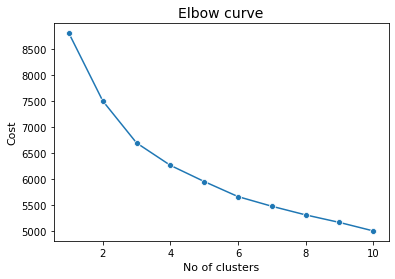

In [20]:
# plot cost against number of clusters
ax = sns.lineplot(x=num_clusters, y=cost, marker="o")
ax.set_title('Elbow curve', fontsize=14)
ax.set_xlabel('No of clusters', fontsize=11)
ax.set_ylabel('Cost', fontsize=11)

Creating of Model

In [19]:
cluster_3 = KPrototypes(n_clusters=3, init='Huang', random_state=42, n_jobs=-1)
cluster_3.fit_predict(smart_array, categorical=[0,1,2,3])
print(cluster_3.cost_)
#new column for cluster labels associated with each subject
bankChurners_Cluster['cluster'] = cluster_3.labels_

6695.352834513835


Identifying Highest Proportion of Attrition

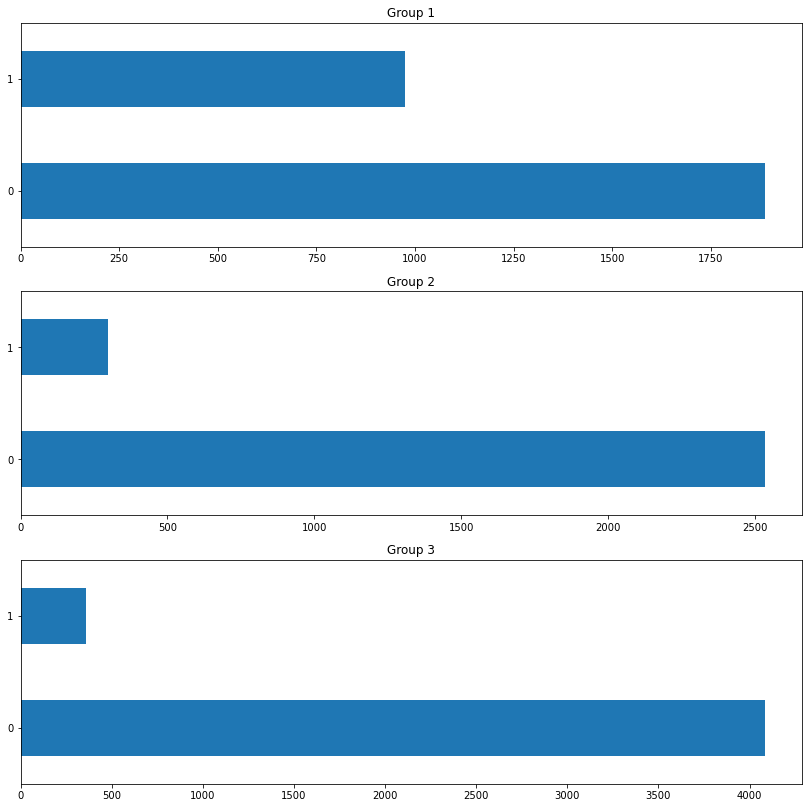

In [20]:
fig, axs = plt.subplots(ncols=1,nrows=3, figsize=(14,14))

bankChurners_Cluster[bankChurners_Cluster['cluster'] == 0]['Attrition_Flag'].value_counts().sort_index().plot.barh(ax=axs[0], title='Group 1')
bankChurners_Cluster[bankChurners_Cluster['cluster'] == 1]['Attrition_Flag'].value_counts().sort_index().plot.barh(ax=axs[1], title='Group 2')
bankChurners_Cluster[bankChurners_Cluster['cluster'] == 2]['Attrition_Flag'].value_counts().sort_index().plot.barh(ax=axs[2], title='Group 3')


# Modelling (Clustered)

In [21]:
# Find Best Cluster: Cluster 1 
cluster_1 = bankChurners_Cluster.loc[bankChurners_Cluster['cluster'] == 0]
cluster_1 = cluster_1.drop('cluster', axis = 1)

# Split target & features
clustered_x = cluster_1.drop('Attrition_Flag', axis=1)
clustered_y = cluster_1['Attrition_Flag']



# Get dummy variables
clustered_x = pd.get_dummies(clustered_x)

# Training
x_train, x_test, y_train, y_test = train_test_split(clustered_x , clustered_y, test_size = 0.2)

# # SMOTE

print(f'''Shape of X before SMOTE:\n {y_train.value_counts()}''')

smote_nc = SMOTE(random_state=0)

x_train, y_train = smote_nc.fit_resample(x_train, y_train)

print(f'''Shape of X after SMOTE:\n {y_train.value_counts()}''')



Shape of X before SMOTE:
 0    1483
1     805
Name: Attrition_Flag, dtype: int64
Shape of X after SMOTE:
 1    1483
0    1483
Name: Attrition_Flag, dtype: int64


Identify best model

In [22]:
lgbm_model = LGBMClassifier().fit(x_train, y_train)
rf_model = RandomForestClassifier().fit(x_train, y_train)
log_model =  LogisticRegression().fit(x_train, y_train)


print('------------- Light Gradient Boosting (Clustered) -------------\n')

print(classification_report(y_test, lgbm_model.predict(x_test)))

print('--------------- Random Forest (Clustered) ---------------\n')

print(classification_report(y_test, rf_model.predict(x_test)))

print('--------------- Logistic Regression (Clustered) ---------------\n')

print(classification_report(y_test, log_model.predict(x_test)))

------------- Light Gradient Boosting (Clustered) -------------

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       403
           1       0.88      0.94      0.91       169

    accuracy                           0.95       572
   macro avg       0.93      0.94      0.94       572
weighted avg       0.95      0.95      0.95       572

--------------- Random Forest (Clustered) ---------------

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       403
           1       0.84      0.92      0.88       169

    accuracy                           0.92       572
   macro avg       0.90      0.92      0.91       572
weighted avg       0.93      0.92      0.93       572

--------------- Logistic Regression (Clustered) ---------------

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       403
           1       0.70      0.86      0.77     

Predictor importance using Light Gradient Boosting (Clustered)

Text(0.5, 0, 'Feature Importance Levels')

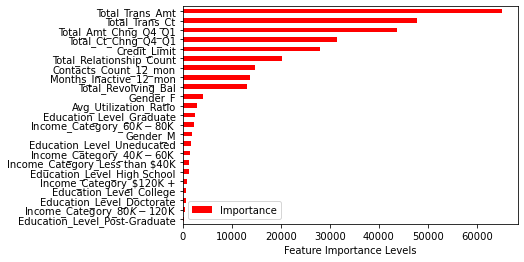

In [24]:
Importance = pd.DataFrame({"Importance": lgbm_model.feature_importances_*100},
                         index = x_train.columns)
Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "r")

plt.xlabel("Feature Importance Levels")


